# Chapter5 案例练习——Python文本挖掘

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [3]:
dtype = {
    "InvoiceNo": "string",
    "StockCode": "string",
    "Description": "string",
    "Quantity": "int32",
    "UnitPrice": "float32",
    "CustomerID": "string",
    "Country": "string"
}

filename = '../data/Online Retail Preprocessing.xlsx'
sales_success = pd.read_excel(filename, sheet_name='Online Retail Preprocessing', dtype=dtype, engine='calamine')

In [4]:
sales_success.dtypes

InvoiceNo        string[python]
StockCode        string[python]
Description      string[python]
Quantity                  int32
InvoiceDate      datetime64[ns]
UnitPrice               float32
CustomerID       string[python]
Country          string[python]
UnitPrice_RMB           float64
SumPrice                float64
Month                     int64
Date             datetime64[ns]
Dayofweek                 int64
Quarter                   int64
Hour                      int64
dtype: object

In [5]:
sales_success.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,UnitPrice_RMB,SumPrice,Month,Date,Dayofweek,Quarter,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,23.1030,138.6180,12,2010-12-01,2,4,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,24.9150,199.3200,12,2010-12-01,2,4,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8


## 数据预处理

### 分组聚合

In [6]:
good_grouped = sales_success.groupby(['StockCode', 'Description'], as_index=False)[['SumPrice','Quantity']].sum()
good_grouped

,StockCode,Description,SumPrice,Quantity
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303
2,10120,DOGGY RUBBER,365.2992,192
3,10123C,HEARTS WRAPPING TAPE,29.4450,5
4,10124A,SPOTS ON RED BOOKCOVER TAPE,60.8832,16
...,...,...,...,...
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1513.4730,10
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1590.3018,7
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,912.3420,3
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1518.0936,4


### 生成热门分类变量

In [7]:
good_grouped['Quantity'].median()

np.float64(323.0)

In [8]:
good_grouped['Quantity'].mean()

np.float64(1339.2021148762317)

以0.8为分位数

In [9]:
threshold = good_grouped['Quantity'].quantile(0.8)
threshold

np.float64(1752.0)

In [10]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=threshold)
good_grouped['Hot'] = binarizer.fit_transform(good_grouped[['Quantity']])

In [11]:
good_grouped.head()

,StockCode,Description,SumPrice,Quantity,Hot
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860,0
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303,0
2,10120,DOGGY RUBBER,365.2992,192,0
3,10123C,HEARTS WRAPPING TAPE,29.4450,5,0
4,10124A,SPOTS ON RED BOOKCOVER TAPE,60.8832,16,0


In [12]:
good_grouped.Hot.value_counts()

Hot
0    3330
1     831
Name: count, dtype: int64

### 词袋模型

In [13]:
X = good_grouped.Description
y = good_grouped.Hot

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_matrix = count_vect.fit_transform(X)
print("X:\n{}".format(repr(X_matrix)))

X:
<4161x2137 sparse matrix of type '<class 'numpy.int64'>'
	with 17872 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = count_vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 2137
First 20 features:
['00' '10' '100' '11' '12' '120cm' '125g' '15' '15c' '15cm' '16' '16954'
 '16955' '16956' '16957' '16960' '16961' '16963' '16965' '16x16cm']
Features 20010 to 20030:
[]
Every 2000th feature:
['00' 'toys']


In [16]:
pd.DataFrame(X_matrix.toarray(), columns=count_vect.get_feature_names_out())

,00,10,100,11,12,120cm,125g,15,15c,15cm,...,wraps,wreath,wrecking,writing,xmas,yellow,you,your,yuletide,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4157,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4158,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4159,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 可视化

In [17]:
!pip install wordcloud

In [18]:
all_words = ' '.join([' '.join(sentence) for sentence in count_vect.inverse_transform(X_matrix)])
all_words

'inflatable political globe inflatable groovy cactus doggy rubber hearts wrapping tape tape spots on red bookcover tape bookcover army camo mini funky design tapes colouring pencils brown tube colouring pencils brown tube design asstd racing car pen fan black frame fan paper pocket traveling fan assorted colours silk fan sandalwood paper pink parasol paper parasol blue paper parasol purple red paper parasol black parasol edwardian parasol edwardian natural pink parasol edwardian black parasol edwardian parasol edwardian natural pink parasol edwardian parasol blue polkadot garden pink parasol polkadot garden design parasol garden ice cream design fairy cake umbrella design fairy cake umbrella small folding scissor pointed edge folding scissor camping knif animal stickers stickers food drink sponge small scissor chinese style scissor chinese style medium scissor chinese style large clear stationery box set mini highlighter pens rubber pop art push down pencils popart wooden asst pen pens

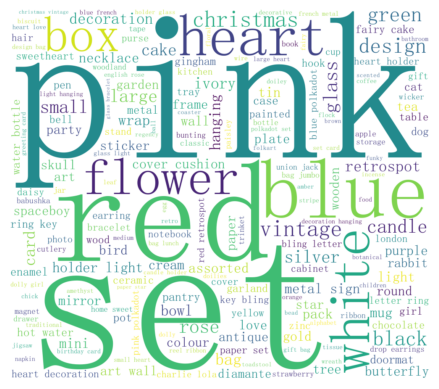

In [19]:
# 生成词云
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator  # 引入词云WordCloud

# WordCloud()设定词云参数，.generate()将str文本生成词云
wordcloud = WordCloud(
    font_path="C:/Windows/Fonts/simfang.ttf", 
    background_color="white",
    width=1000,
    height=880,
).generate(all_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# wordcloud.to_file("cloud1.jpg") # 保存图片

## 文本分类

### 训练集-测试集划分

In [20]:
from sklearn.model_selection import train_test_split

X = good_grouped.Description
y = good_grouped.Hot
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_matrix = count_vect.fit_transform(X_train)
X_test_matrix = count_vect.transform(X_test)
print("X_train:\n{}".format(repr(X_train_matrix)))

X_train:
<2912x1846 sparse matrix of type '<class 'numpy.int64'>'
	with 12489 stored elements in Compressed Sparse Row format>


In [22]:
feature_names = count_vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 1846
First 20 features:
['00' '10' '11' '12' '120cm' '125g' '15cm' '16' '16954' '16956' '16957'
 '16960' '16961' '16963' '16965' '16x16cm' '17067' '17068' '17070' '17074']
Features 20010 to 20030:
[]
Every 2000th feature:
['00']


In [23]:
pd.DataFrame(X_train_matrix.toarray(), columns=count_vect.get_feature_names_out())

,00,10,11,12,120cm,125g,15cm,16,16954,16956,...,wraps,wreath,wrecking,writing,xmas,yellow,you,your,yuletide,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 分类算法

#### LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_matrix, y_train)
y_pred = lr.predict(X_test_matrix)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8366693354683747

In [26]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, lr.predict_proba(X_test_matrix)[:, 1]):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       997
           1       0.68      0.36      0.47       252

    accuracy                           0.84      1249
   macro avg       0.77      0.66      0.69      1249
weighted avg       0.82      0.84      0.82      1249

AUC-ROC: 0.84


#### 朴素贝叶斯

In [27]:
from sklearn.naive_bayes import MultinomialNB

# 训练朴素贝叶斯分类器
nb = MultinomialNB()
nb.fit(X_train_matrix, y_train)

y_pred = nb.predict(X_test_matrix)

In [28]:
# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, nb.predict_proba(X_test_matrix)[:, 1]):.2f}")

Accuracy: 0.825

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       997
           1       0.59      0.42      0.49       252

    accuracy                           0.82      1249
   macro avg       0.73      0.68      0.69      1249
weighted avg       0.81      0.82      0.81      1249

AUC-ROC: 0.81


#### SVM

In [29]:
from sklearn.svm import SVC

# 训练SVM分类器
svm = SVC(kernel='rbf', probability=True, random_state=0)
svm.fit(X_train_matrix, y_train)

# 预测
y_pred = svm.predict(X_test_matrix)

In [30]:
# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, svm.predict_proba(X_test_matrix)[:, 1]):.2f}")

Accuracy: 0.835

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       997
           1       0.76      0.27      0.39       252

    accuracy                           0.84      1249
   macro avg       0.80      0.62      0.65      1249
weighted avg       0.82      0.84      0.80      1249

AUC-ROC: 0.83


#### 决策树

In [31]:
from sklearn.tree import DecisionTreeClassifier

# 训练决策树分类器
dt = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=5)
dt.fit(X_train_matrix, y_train)

y_pred = dt.predict(X_test_matrix)

In [32]:
# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, dt.predict_proba(X_test_matrix)[:, 1]):.2f}")

Accuracy: 0.802

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       997
           1       0.52      0.21      0.30       252

    accuracy                           0.80      1249
   macro avg       0.68      0.58      0.59      1249
weighted avg       0.77      0.80      0.77      1249

AUC-ROC: 0.57


#### 随机森林

In [33]:
from sklearn.ensemble import RandomForestClassifier

# 训练随机森林分类器
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
rf.fit(X_train_matrix, y_train)

# 预测
y_pred = rf.predict(X_test_matrix)

In [34]:
# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, rf.predict_proba(X_test_matrix)[:, 1]):.2f}")

Accuracy: 0.799

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       997
           1       1.00      0.00      0.01       252

    accuracy                           0.80      1249
   macro avg       0.90      0.50      0.45      1249
weighted avg       0.84      0.80      0.71      1249

AUC-ROC: 0.79


### 特征工程优化

In [35]:
from sklearn.model_selection import train_test_split
X = good_grouped.Description
y = good_grouped.Hot

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

#### 文本清洗和选择

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def custom_tokenizer(document):
    document = re.sub(r'[^a-zA-Z\s]', '', document)
    return document.split()

count_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=2, max_df=0.95, stop_words="english", ngram_range=(1, 2), token_pattern=None)

In [37]:
count_vect = CountVectorizer(min_df=2, max_df=0.95, stop_words="english", ngram_range=(1, 2))

In [38]:
X_train_matrix = count_vect.fit_transform(X_train)
X_test_matrix = count_vect.transform(X_test)

In [39]:
pd.DataFrame(X_train_matrix.toarray(), columns=count_vect.get_feature_names_out())

,00,10,10 card,10 cards,12,12 blue,12 colour,12 coloured,12 lights,12 pencils,...,xmas,yellow,yellow flowers,yellow pink,zinc,zinc glass,zinc heart,zinc light,zinc star,zinc wire
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
lr = LogisticRegression()
lr.fit(X_train_matrix, y_train)
y_pred = lr.predict(X_test_matrix)

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8390712570056045

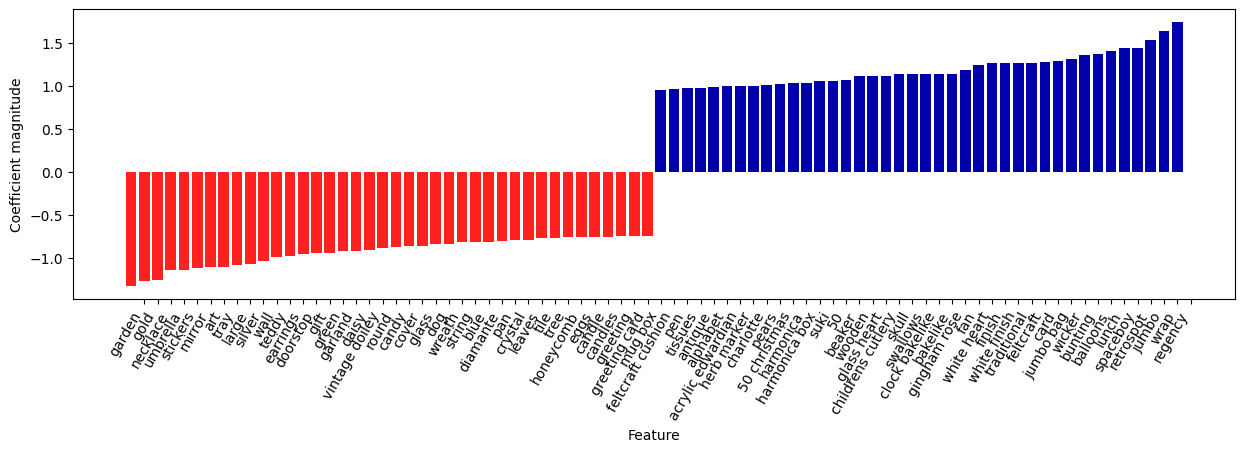

In [42]:
import mglearn
feature_names = np.array(count_vect.get_feature_names_out())
coef = lr.coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.show()

#### TfidfVectorizer

In [43]:
from sklearn.model_selection import train_test_split
X = good_grouped.Description
y = good_grouped.Hot

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(min_df=2, max_df=0.95, stop_words="english", ngram_range=(1, 3))

In [45]:
X_train_matrix = tfidf_vect.fit_transform(X_train)
X_test_matrix = tfidf_vect.transform(X_test)

In [46]:
lr = LogisticRegression()
lr.fit(X_train_matrix, y_train)
y_pred = lr.predict(X_test_matrix)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8286629303442754

## 文本聚类

### KMeans聚类

#### 数据预处理

In [48]:
X = good_grouped.Description

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(X)

#### 聚类建模

In [50]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=5)
clf.fit(tfidf_matrix)
cluster_labels = clf.labels_
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], shape=(4161,), dtype=int32)

In [51]:
good_grouped['cluster_labels'] = cluster_labels
good_grouped

,StockCode,Description,SumPrice,Quantity,Hot,cluster_labels
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860,0,0
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303,0,0
2,10120,DOGGY RUBBER,365.2992,192,0,0
3,10123C,HEARTS WRAPPING TAPE,29.4450,5,0,0
4,10124A,SPOTS ON RED BOOKCOVER TAPE,60.8832,16,0,1
...,...,...,...,...,...,...
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1513.4730,10,0,0
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1590.3018,7,0,0
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,912.3420,3,0,0
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1518.0936,4,0,0


In [52]:
good_grouped.groupby('cluster_labels').Description.count()

cluster_labels
0    2776
1     234
2     291
3     446
4     414
Name: Description, dtype: int64

In [53]:
good_grouped[good_grouped['cluster_labels'] == 0]

,StockCode,Description,SumPrice,Quantity,Hot,cluster_labels
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860,0,0
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303,0,0
2,10120,DOGGY RUBBER,365.2992,192,0,0
3,10123C,HEARTS WRAPPING TAPE,29.4450,5,0,0
5,10124G,ARMY CAMO BOOKCOVER TAPE,64.6884,17,0,0
...,...,...,...,...,...,...
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1513.4730,10,0,0
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1590.3018,7,0,0
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,912.3420,3,0,0
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1518.0936,4,0,0


## 信息检索

### 相似度查找

#### 数据预处理

In [54]:
X = good_grouped.Description

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(X)

#### 相似度计算

In [56]:
query_descritpion = 'SILVER MINI TAPE MEASURE'
query_document = pd.Series(query_descritpion)
query_tfidf_vector = tfidf_vect.transform(query_document)
query_tfidf_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 2137))

In [57]:
# 计算相似度
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(query_tfidf_vector, tfidf_matrix)

In [58]:
similarity_scores = cosine_similarities[0]
similarity_scores

array([0., 0., 0., ..., 0., 0., 0.], shape=(4161,))

找到最相似的文档

In [59]:
doc_scores = []
similarity_scores = cosine_similarities[0]
for i, score in enumerate(similarity_scores):
    doc_scores.append((i, score))
sorted_doc_scores = sorted(doc_scores, key=lambda x: x[1], reverse=True)
sorted_doc_scores[:10]

[(186, np.float64(1.0000000000000002)),
 (187, np.float64(0.8579243663233392)),
 (185, np.float64(0.832004716357922)),
 (881, np.float64(0.36765205778658056)),
 (883, np.float64(0.3643759939799675)),
 (880, np.float64(0.3223271067695699)),
 (884, np.float64(0.30705698630158806)),
 (1369, np.float64(0.27524120229657323)),
 (1370, np.float64(0.2726922198260805)),
 (3, np.float64(0.27262066217203695))]

In [60]:
print(f"Query Document: '{query_document.iloc[0]}'")
print("Most similar documents:")
for index, score in sorted_doc_scores[:5]: # 显示最相似的前5个
    print(f"- Document {index+1}: - StockCode: {good_grouped.iloc[index][0]} - Description: '{good_grouped.iloc[index][1]}' (Similarity: {score:.4f})")

Query Document: 'SILVER MINI TAPE MEASURE'
Most similar documents:
- Document 187: - StockCode: 20734 - Description: 'SILVER MINI TAPE MEASURE ' (Similarity: 1.0000)
- Document 188: - StockCode: 20735 - Description: 'BLACK MINI TAPE MEASURE ' (Similarity: 0.8579)
- Document 186: - StockCode: 20733 - Description: 'GOLD MINI TAPE MEASURE ' (Similarity: 0.8320)
- Document 882: - StockCode: 21880 - Description: 'RED RETROSPOT TAPE' (Similarity: 0.3677)
- Document 884: - StockCode: 21882 - Description: 'SKULLS TAPE' (Similarity: 0.3644)


## 主题建模

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
tfidf_matrix = tfidf_vect.fit_transform(X)

In [62]:
tfidf_matrix.shape

(4161, 2077)

### 潜在语义分析（LSA）

In [63]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=100,
                         algorithm='randomized',
                         n_iter=10)

svd_matrix = svd_model.fit_transform(tfidf_matrix)

$U_k * \Sigma_k$：文档-主题矩阵在降维后的新空间中的表示

In [64]:
svd_matrix

array([[ 4.09245874e-06, -2.27826775e-06,  4.04400677e-07, ...,
         3.16866775e-04, -4.52352925e-05,  1.44837490e-05],
       [ 7.13743548e-04, -2.92709932e-04,  4.39212989e-05, ...,
         7.35898580e-03, -1.37192536e-03,  4.26863215e-04],
       [ 1.81424805e-04, -7.50476528e-05,  1.35531502e-04, ...,
        -8.93416862e-04,  1.90083601e-03,  1.66408014e-04],
       ...,
       [ 2.05555474e-02, -2.70596619e-02, -1.47988080e-02, ...,
         1.00432993e-02,  2.13678805e-02,  2.31283558e-02],
       [ 2.71710991e-02, -3.45716643e-02, -2.24177524e-02, ...,
        -5.42697374e-03,  2.61416341e-02,  1.56534901e-02],
       [-1.77615280e-17, -5.13746255e-16,  8.32274819e-15, ...,
        -3.80446646e-08,  3.93052670e-09,  2.54086721e-08]],
      shape=(4161, 100))

In [65]:
svd_matrix.shape

(4161, 100)

$V_k^T$：主题-单词矩阵在降维后的新空间中的表示

In [66]:
print("\n成分矩阵 (svd.components_):")
print(svd_model.components_)


成分矩阵 (svd.components_):
[[ 1.20886760e-03  3.82017939e-02  1.72763166e-04 ...  2.39253465e-02
   1.53821108e-03  8.15449855e-02]
 [-2.22940293e-03 -5.57139814e-02 -3.23958027e-04 ...  6.54149138e-03
  -2.84174518e-03  1.12491507e-01]
 [-1.61740789e-03 -6.19759059e-02 -1.89686674e-04 ...  2.20303540e-02
  -2.45540006e-03 -7.13175611e-02]
 ...
 [ 4.02704032e-03  1.53497630e-02  6.67264876e-04 ... -6.35641461e-04
   8.59412041e-04  1.14582554e-02]
 [ 7.15549980e-03  2.22380892e-02  9.92784070e-04 ... -2.08609892e-02
   3.15015854e-04 -1.42126590e-01]
 [ 8.07548371e-03  3.26503008e-02  1.26964229e-03 ... -9.60234406e-05
   5.10522845e-03 -2.20554579e-02]]


In [67]:
svd_model.components_.shape

(100, 2077)

In [68]:
print(svd_model.explained_variance_)

[0.00540088 0.01005809 0.0087258  0.00826737 0.00790602 0.00765834
 0.00765915 0.0070599  0.00667306 0.0064649  0.00647016 0.00629027
 0.00614429 0.00610302 0.00572803 0.0055623  0.00543954 0.00532406
 0.00525432 0.00501016 0.00491334 0.00489789 0.00478868 0.00472318
 0.00468314 0.00459283 0.00453698 0.00447762 0.00445329 0.00443926
 0.00435828 0.00423934 0.0041953  0.00417639 0.0041501  0.00407291
 0.00397994 0.00388217 0.00385833 0.00382137 0.00374667 0.00372918
 0.00367362 0.0036336  0.0035383  0.003474   0.00339956 0.00339929
 0.00333705 0.0032962  0.00326453 0.00321241 0.00319984 0.00315006
 0.00310078 0.00303798 0.0029777  0.00293953 0.00293896 0.00292368
 0.00289421 0.00286219 0.00285068 0.00280136 0.00278673 0.00274812
 0.00273341 0.00270368 0.00268705 0.00266963 0.00264037 0.0025794
 0.00257921 0.00254824 0.0025229  0.00251712 0.00249938 0.00248832
 0.0024644  0.00244821 0.00243211 0.00242533 0.00240904 0.00239797
 0.0023457  0.00233339 0.0023072  0.00228534 0.00227006 0.00225

In [69]:
svd_model.singular_values_

array([7.6110558 , 6.55266604, 6.03756861, 5.86880513, 5.74160389,
       5.66424023, 5.65738102, 5.45271882, 5.28129473, 5.2261393 ,
       5.19614157, 5.12357831, 5.06306559, 5.0555264 , 4.89302456,
       4.81858894, 4.76500695, 4.70674078, 4.67640322, 4.56709308,
       4.52720662, 4.51670236, 4.48175221, 4.44189163, 4.41735175,
       4.38072612, 4.34542219, 4.32016978, 4.30675859, 4.29863516,
       4.27866852, 4.20316059, 4.18245281, 4.16941335, 4.16010122,
       4.12860391, 4.06947705, 4.02127862, 4.0072772 , 3.99055982,
       3.9507357 , 3.9397053 , 3.91608698, 3.88846757, 3.83707803,
       3.80473433, 3.76971859, 3.76253527, 3.72733438, 3.70517261,
       3.68563342, 3.65627043, 3.65211595, 3.62090072, 3.59492806,
       3.55566213, 3.52039514, 3.50316868, 3.49742132, 3.48827669,
       3.47209348, 3.45474823, 3.44432752, 3.41411359, 3.40563596,
       3.38263272, 3.37247812, 3.35630094, 3.34441364, 3.3351815 ,
       3.31514445, 3.28295263, 3.27628435, 3.25686816, 3.24155

### LDA主题建模

#### 数据预处理

In [70]:
X = good_grouped.Description

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_matrix = count_vect.fit_transform(X)

#### 建模

In [72]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10  # 主题数，根据需求调整
lda = LatentDirichletAllocation(n_components=n_topics,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

In [73]:
document_topics = lda.fit_transform(X_matrix)

In [74]:
lda.components_.shape

(10, 2137)

In [75]:
def print_topics(model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" | ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))

print("----- 主题关键词分布 -----")
print_topics(lda, count_vect)

----- 主题关键词分布 -----
Topic #0:
ring | key | pink | letter | bling | reel | ribbon | bracelet | sweetheart | white
Topic #1:
cake | of | mug | design | set | tea | fairy | stand | pink | plate
Topic #2:
red | glass | necklace | retrospot | bracelet | green | silver | charm | heart | bead
Topic #3:
12 | clock | bottle | girl | dolly | pack | party | hot | wall | water
Topic #4:
bag | metal | blue | pink | vintage | sign | wrap | paper | paisley | easter
Topic #5:
earrings | pink | vintage | frame | black | mirror | blue | photo | felt | drop
Topic #6:
set | of | box | garden | 10 | cutlery | lights | cards | paper | vintage
Topic #7:
christmas | decoration | heart | hanging | with | love | tree | pink | bird | cushion
Topic #8:
holder | light | heart | wall | art | ivory | small | large | hanging | candle
Topic #9:
rose | card | assorted | home | in | hook | vintage | doormat | box | candle


In [76]:
topic_names = ["Topic_" + str(i) for i in range(n_topics)]
doc_topic_df = pd.DataFrame(document_topics, columns=topic_names)
doc_topic_df['Dominant_Topic'] = doc_topic_df.idxmax(axis=1)
results = pd.concat([good_grouped['Description'], doc_topic_df], axis=1)
results

,Description,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Dominant_Topic
0,INFLATABLE POLITICAL GLOBE,0.025000,0.025003,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.774997,Topic_9
1,GROOVY CACTUS INFLATABLE,0.025000,0.774990,0.025000,0.025000,0.025000,0.025000,0.025007,0.025000,0.025000,0.025003,Topic_1
2,DOGGY RUBBER,0.033333,0.033354,0.033333,0.033333,0.699979,0.033333,0.033333,0.033333,0.033333,0.033333,Topic_4
3,HEARTS WRAPPING TAPE,0.025000,0.025000,0.025000,0.025001,0.774973,0.025003,0.025005,0.025018,0.025000,0.025001,Topic_4
4,SPOTS ON RED BOOKCOVER TAPE,0.016667,0.016667,0.016677,0.576341,0.016674,0.016672,0.016667,0.290298,0.016669,0.016668,Topic_3
...,...,...,...,...,...,...,...,...,...,...,...,...
4156,Dotcomgiftshop Gift Voucher £20.00,0.849979,0.016667,0.016667,0.016667,0.016669,0.016667,0.016667,0.016668,0.016667,0.016682,Topic_0
4157,Dotcomgiftshop Gift Voucher £30.00,0.849994,0.016667,0.016667,0.016667,0.016670,0.016667,0.016667,0.016667,0.016667,0.016668,Topic_0
4158,Dotcomgiftshop Gift Voucher £40.00,0.651486,0.016667,0.016667,0.016668,0.016670,0.016667,0.016667,0.016667,0.016667,0.215175,Topic_0
4159,Dotcomgiftshop Gift Voucher £50.00,0.849977,0.016667,0.016668,0.016667,0.016669,0.016667,0.016670,0.016679,0.016667,0.016668,Topic_0


## 课堂练习